# Trading strategy on real data only

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

In [2]:
# === Load data ===
df = pd.read_csv('data/data_preprocessed.csv', index_col=0, parse_dates=True)
regimes = pd.read_csv('data/regimes.csv', index_col=0, parse_dates=True)['0']
returns = df.pct_change().dropna()

In [3]:
# === Split into train/test ===
split_idx = int(len(returns) * 0.7)
train_returns = returns.iloc[:split_idx]
test_returns = returns.iloc[split_idx:]
test_regimes = regimes.loc[test_returns.index]

### Cross-Sectional Momentum Trading Strategy

1. **Lagged Return Ranking**:
   - For each day `t`, compute returns from **day `t-1`** for all assets.
   - Rank assets **cross-sectionally** based on those lagged returns.

2. **Signal Generation**:
   - Go **long** (buy) the top `quantile` of assets (e.g. top 20%).
   - Go **short** (sell) the bottom `quantile` of assets (e.g. bottom 20%).

3. **Portfolio Construction**:
   - Assign **equal weights** within each group.
   - The portfolio is **dollar-neutral**, meaning total long and short exposures are balanced.
   - Positions are **updated daily** based on the latest ranks.

In [4]:
# === Define our strategy ===
def cross_sectional_momentum_strategy(returns, quantile=0.2):
    lagged = returns.shift(1)
    ranks = lagged.rank(axis=1, pct=True)

    long_mask = (ranks >= 1 - quantile).astype(int)
    short_mask = (ranks <= quantile).astype(int) * -1

    weights = long_mask + short_mask
    weights = weights.div(weights.abs().sum(axis=1), axis=0).fillna(0)

    strat_returns = (weights * returns).sum(axis=1)
    return strat_returns


### Parameter

- **`quantile`**: controls the top/bottom percentage of assets traded (typical values: 0.1 to 0.3).

This is the only hyperparameter and is calibrated to maximize **Sharpe ratio** on a training set.


In [5]:
# === Calibration metric ===
def sharpe_ratio(r):
    return r.mean() / r.std() * np.sqrt(252)

# === Grid search on train set ===
param_grid = {'quantile': [0.1, 0.15, 0.2, 0.25, 0.3]}
results = []

for params in ParameterGrid(param_grid):
    r = cross_sectional_momentum_strategy(train_returns, **params)
    s = sharpe_ratio(r)
    results.append((params['quantile'], s))

results_df = pd.DataFrame(results, columns=['quantile', 'Sharpe'])
best_param = results_df.sort_values(by='Sharpe', ascending=False).iloc[0]['quantile']

In [7]:
best_param

0.15

### Evaluation Approach

- **Train/test split**: we calibrate `quantile` on 70% of the real data  
- **Backtest**: evaluate out-of-sample performance on the remaining 30%  
- **Regime-based analysis**: test how the strategy performs under Bull, Bear, and Risky conditions

Performance is measured using:

- **Sharpe ratio**  
- **Cumulative return**  
- **Max drawdown**  
- **Regime-wise statistics**

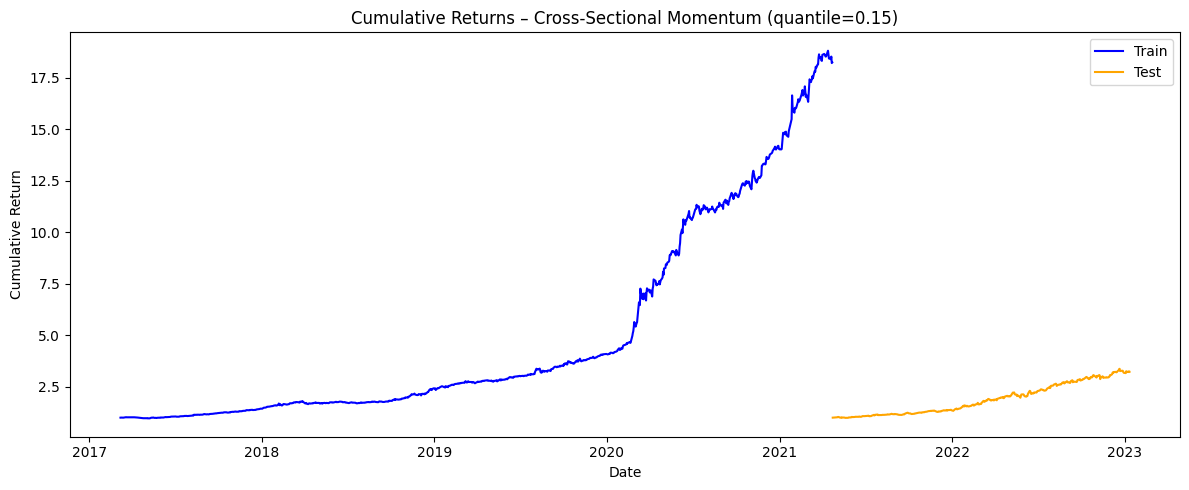

In [11]:
# === Train & test strategy using best quantile ===
train_strategy = cross_sectional_momentum_strategy(train_returns, quantile=best_param)
test_strategy  = cross_sectional_momentum_strategy(test_returns,  quantile=best_param)

# === Cumulative return plot ===
cum_train = (1 + train_strategy).cumprod()
cum_test  = (1 + test_strategy).cumprod()

plt.figure(figsize=(12,5))
plt.plot(cum_train, label='Train', color='blue')
plt.plot(cum_test,  label='Test',  color='orange')
plt.title(f"Cumulative Returns – Cross-Sectional Momentum (quantile={best_param:.2f})")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# === Global performance metrics ===
def performance_metrics(r):
    cum = (1 + r).cumprod()
    dd = cum / cum.cummax() - 1
    return pd.Series({
        'Annual Return': r.mean() * 252,
        'Annual Volatility': r.std() * np.sqrt(252),
        'Sharpe Ratio': sharpe_ratio(r),
        'Max Drawdown': dd.min()
    }).round(4)

print("=== Overall Test Performance ===")
print(performance_metrics(test_strategy))

# === Regime-wise evaluation ===
def regime_perf(r, regimes):
    df = pd.DataFrame({'r': r, 'Regime': regimes})
    grouped = df.groupby('Regime')['r'].agg(['mean','std','count'])
    grouped['Sharpe'] = grouped['mean'] / grouped['std'] * np.sqrt(252)
    return grouped.round(4)

print("\n=== Regime-wise Sharpe (Test Set) ===")
print(regime_perf(test_strategy, test_regimes))


=== Overall Test Performance ===
Annual Return        0.7058
Annual Volatility    0.2232
Sharpe Ratio         3.1626
Max Drawdown        -0.1154
dtype: float64

=== Regime-wise Sharpe (Test Set) ===
          mean     std  count  Sharpe
Regime                               
Bear    0.0045  0.0143    215  4.9846
Bull    0.0011  0.0137    219  1.3331


# Trading strategy on real data + augmented data in training

In [12]:
# === Load data ===
aug = pd.read_csv("data/augmented_prices.csv", index_col=0, parse_dates=True)

returns_aug = aug.pct_change().dropna()

In [13]:
# === Define real-only boundaries ===
real_prices = pd.read_csv("data/data_preprocessed.csv", index_col=0, parse_dates=True)
real_index = real_prices.index
split_idx = int(len(real_index) * 0.7)

train_real_idx = real_index[:split_idx]
test_real_idx  = real_index[split_idx:]

# === Rebuild train and test ===
train_returns_aug = returns_aug.loc[~returns_aug.index.isin(test_real_idx)]  # includes real+synthetic
test_returns_real = returns_aug.loc[test_real_idx]                           # test remains real
test_regimes      = regimes.loc[test_real_idx]


In [14]:
# === Grid search calibration on extended training set ===
param_grid = {'quantile': [0.1, 0.15, 0.2, 0.25, 0.3]}
results_aug = []

for params in ParameterGrid(param_grid):
    r = cross_sectional_momentum_strategy(train_returns_aug, **params)
    s = sharpe_ratio(r)
    results_aug.append((params['quantile'], s))

results_df_aug = pd.DataFrame(results_aug, columns=['quantile', 'Sharpe'])
best_param_aug = results_df_aug.sort_values(by='Sharpe', ascending=False).iloc[0]['quantile']


In [15]:
best_param_aug

0.1

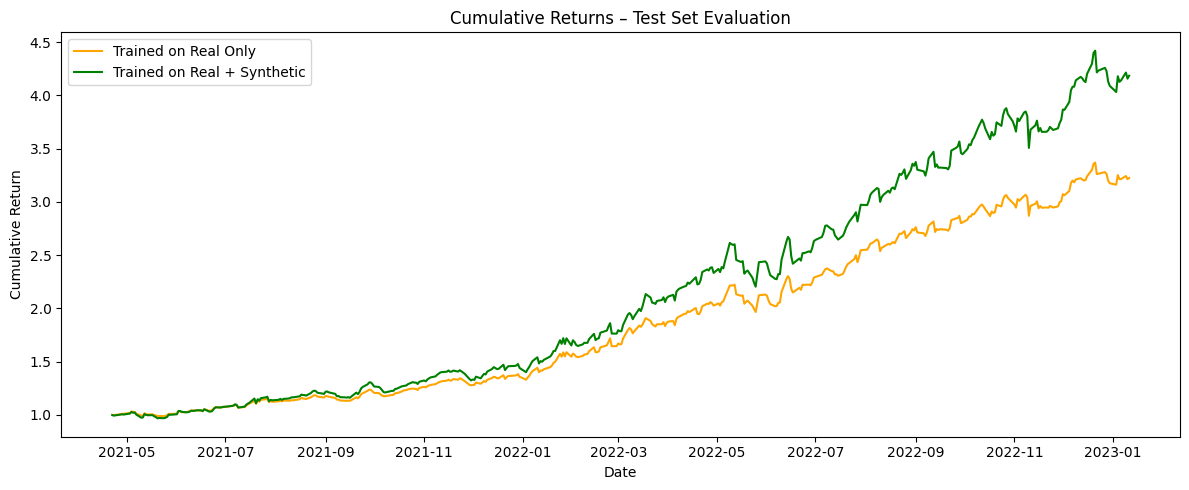

In [16]:
# === Evaluate on the same test set as before ===
test_strategy_aug = cross_sectional_momentum_strategy(test_returns_real, quantile=best_param_aug)

# === Plot cumulative returns ===
cum_test_aug = (1 + test_strategy_aug).cumprod()

plt.figure(figsize=(12,5))
plt.plot(cum_test,     label='Trained on Real Only', color='orange')
plt.plot(cum_test_aug, label='Trained on Real + Synthetic', color='green')
plt.title("Cumulative Returns – Test Set Evaluation")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
print("=== Performance on Test Set (Trained on Real + Synthetic) ===")
print(performance_metrics(test_strategy_aug))
print("\n=== Regime-wise Sharpe (Test Set) – Real+Synthetic Training ===")
print(regime_perf(test_strategy_aug, test_regimes))

=== Performance on Test Set (Trained on Real + Synthetic) ===
Annual Return        0.8726
Annual Volatility    0.2898
Sharpe Ratio         3.0108
Max Drawdown        -0.1571
dtype: float64

=== Regime-wise Sharpe (Test Set) – Real+Synthetic Training ===
          mean     std  count  Sharpe
Regime                               
Bear    0.0052  0.0184    215  4.4750
Bull    0.0018  0.0180    220  1.5645


## Impact of Synthetic Data on Strategy Calibration

We compared the performance of a cross-sectional momentum strategy trained on two datasets:

- Real data only (70% of the original time period)
- Real data augmented with synthetic returns (via VAE)

The evaluation was conducted on the same real out-of-sample test set, allowing for a controlled comparison of generalization performance.

### Overall Performance

The strategy trained on real data only achieved a higher Sharpe ratio and lower drawdown, while the augmented version delivered a higher annual return with increased volatility. This indicates that the augmented strategy took on more risk in pursuit of higher gains. Despite the slight drop in Sharpe, the performance remained strong, suggesting robustness.

### Regime-Wise Analysis

In Bear market conditions, the strategy trained on real data slightly outperformed, achieving the highest regime-specific Sharpe ratio. However, in Bull markets, the augmented strategy provided better generalization, leading to improved performance. This suggests that synthetic data helped the strategy better capture patterns relevant to rising markets, which may have been underrepresented in the original training period.

### Conclusion

Incorporating synthetic data into the training set improved absolute performance and generalization, particularly in Bull regimes. While volatility and drawdown increased modestly, the Sharpe ratio remained competitive. These results support the use of generative augmentation for enhancing the robustness of systematic trading strategies without compromising risk-adjusted returns.
